## Coding Exercise 14

Task 1. For each review included in the dataset, use `spacytextblob` and its inherent document-level scores to get the polarity score of the text. Create a violinplot with the x-axis being individual reviews' star rating, and the y-axis being the calculated polarity scores. Interpret the results. 

In [11]:
!python -m textblob.download_corpora
!pip install textblob
!pip install spacytextblob
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /Users/gohtk/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gohtk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gohtk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gohtk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /Users/gohtk/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/gohtk/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via

In [14]:
import os
import pandas as pd
import re
import json
from tqdm import tqdm
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
os.chdir('/Users/[editted]/Dropbox/work/compsoc/dataset')
os.listdir()
nlp.add_pipe('spacytextblob')

In [167]:
review_ids = []
ratings = []
polarity_scores = []
subjective_scores = []
subjective_phrases = []
with open('yelp_academic_dataset_review_Nov2022_small.jsonl', 'r') as f:
    line_index = 0
    for line in tqdm(f):
        line_index += 1
        review_dict = json.loads(line)

        review = review_dict['text']
        rating = review_dict['stars']
        review_id = review_dict['review_id']

        review_doc = nlp(review)
        subjective_phrases_in_doc = []
        polarity_score = 0
        subjective_score = 0
        
        for assess_tuple in review_doc._.blob.sentiment_assessments.assessments:
            subjective_phrases_in_doc.append(' '.join(assess_tuple[0]))
            polarity_score += assess_tuple[1]
            subjective_score += assess_tuple[2]
            
        ratings.append(rating)
        polarity_scores.append(polarity_score)
        subjective_scores.append(subjective_score)
        review_ids.append(review_id)
        subjective_phrases.append(subjective_phrases_in_doc)
        
yelp_df = pd.DataFrame(columns=['review_id', 'rating', 'polarity_score', 'subjective_score'])
yelp_df['rating'] = ratings
yelp_df['review_id'] = review_ids
yelp_df['polarity_score'] = polarity_scores
yelp_df['subjective_score'] = subjective_scores
yelp_df['subjective_phrase'] = subjective_phrases
yelp_df.describe()            

10000it [02:36, 63.77it/s]


,rating,polarity_score,subjective_score
count,10000.000000,10000.000000,10000.000000
mean,3.854300,2.628267,6.472902
std,1.346719,2.597190,5.194391
min,1.000000,-6.522330,0.000000
25%,3.000000,1.036301,3.100000
50%,4.000000,2.300000,5.065000
75%,5.000000,3.802841,8.176865
max,5.000000,28.070649,59.124542


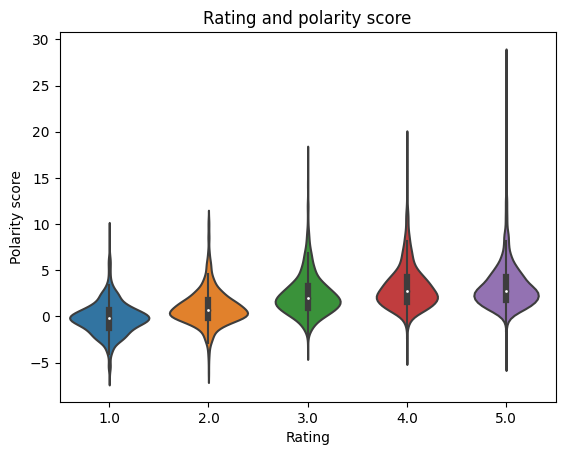

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(y='polarity_score', x='rating', data=yelp_df)

plt.title("Rating and polarity score")
plt.xlabel("Rating")
plt.ylabel("Polarity score")

plt.show()
plt.close()

Polarity score in the token level ranges between -1 and 1. If polarity score is closer to 1, it means the token has a positive sense while -1 of polarity score indicates a negative sense. However, this result is in document level. Therefore, we assume that polarity score larger than 0 indicates the positive sense while that smaller than 0 refers to a negative sense. 
The violin plot shows the positive correlationship between rating and polarity score. When rating is 1, which is the lowest rating for the restaurant's service and foods, the range of polarity score is from -6.5 to 10 and its mean is lower than 0. This indicates that people post a review with negative words when their experiences were bad. From 3 of rating score, the average polarity score is clearly higher than 0. Especially, people who highly satisfied to the restaurant are likely to post a review with highly positive words. 

### Task 2. 
For each review included in the dataset, extract the subjective phrases in the text using  `spacytextblob` and its `sentiment_assessments.assessments` feature. Then, for each review whose review_id is in the following `target_review_ids` list, find the top 3 reviews that are most similar to it in terms of their subjective phrases. 

In [230]:
target_review_ids = ["40thYphUgIfvJq17QCfTwA", "E9AB7V4z8xrt2uPF7T55FQ", "4PHFo_GRG4FEk1q4X7xQVQ", 
                     "4KpIldEM-tdnrJLqYzRfZQ", "PDHRlnEdkEcwATry4w71PQ", "meGaFP7yxQdjyABrYDVeoQ", 
                     "pgESDcC7eDx4z_epqon4_Q", "qeSxL-POvGLZD6aQ5O9kvw"]

for i in range(len(target_review_ids)):
    spacy_encoding = np.array([float(0) for n in range(96)])
    token_count = 0
    reference_phrase = nlp(str(yelp_df.subjective_phrase[yelp_df.review_id==target_review_ids[i]]))
    for token in reference_phrase:
        if token.is_alpha:
            token_count +=1
            spacy_encoding += np.array(token.vector)
    spacy_encoding/=token_count
    reference_se=spacy_encoding
    yelp_df['cosine_similarity_'+str(i)]=None

    for j in range(len(target_review_ids)):
        
        yelp_ids=yelp_df.loc[(yelp_df.review_id==target_review_ids[j])]
        yelp_phrase=str(yelp_ids.subjective_phrase)
        token_count1 = 0
        spacy_encoding1 = np.array([float(0) for i in range(96)])
        for token in nlp(yelp_phrase):
            if token.is_alpha:
                token_count1 +=1
                spacy_encoding1 += np.array(token.vector)
        spacy_encoding1/=token_count1
        cosine_similarity= 1 - cosine(reference_se, spacy_encoding1) 
        yelp_df['cosine_similarity_'+str(i)].loc[(yelp_df.review_id==target_review_ids[j])]=cosine_similarity
         
yelp_similarity=yelp_df[yelp_df.review_id.isin(target_review_ids)]
yelp_similarity

/var/folders/1b/s20n0f295fn5s0f986q3fppc0000gn/T/ipykernel_13688/1218991261.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_df['cosine_similarity_'+str(i)].loc[(yelp_df.review_id==target_review_ids[j])]=cosine_similarity


,review_id,rating,polarity_score,subjective_score,subjective_phrase,cosine_similarity_0,cosine_similarity_1,cosine_similarity_2,cosine_similarity_3,cosine_similarity_4,cosine_similarity_5,cosine_similarity_6,cosine_similarity_7
32,40thYphUgIfvJq17QCfTwA,5.0,2.166667,3.350000,"[great, nice, clean, huge]",1,0.938877,0.7999,0.773774,0.811679,0.742797,0.907562,0.698545
39,E9AB7V4z8xrt2uPF7T55FQ,5.0,1.660000,2.490000,"[amazing, blank, great, highly, busy]",0.938877,1,0.792931,0.821287,0.887475,0.763883,0.931029,0.783763
66,4KpIldEM-tdnrJLqYzRfZQ,5.0,3.250000,5.550000,"[only, awesome !, freshly filled, phenomenal, ...",0.773774,0.821287,0.855609,1,0.836356,0.807932,0.847745,0.861927
73,PDHRlnEdkEcwATry4w71PQ,1.0,-0.864286,3.557143,"[plain, unable, back, actual, back, awkwardly,...",0.811679,0.887475,0.766488,0.836356,1,0.733074,0.893279,0.855108
84,meGaFP7yxQdjyABrYDVeoQ,1.0,-0.233333,2.216667,"[seriously, chicken, good]",0.742797,0.763883,0.80419,0.807932,0.733074,1,0.773633,0.799327
96,4PHFo_GRG4FEk1q4X7xQVQ,5.0,2.744697,8.354545,"[great ! ! ! ! ! ! ! ! !, completely new, othe...",0.7999,0.792931,1,0.855609,0.766488,0.80419,0.778933,0.802779
347,qeSxL-POvGLZD6aQ5O9kvw,1.0,3.271825,32.216270,"[rarely, honestly, worst, objectively horrible...",0.698545,0.783763,0.802779,0.861927,0.855108,0.799327,0.811827,1
424,pgESDcC7eDx4z_epqon4_Q,1.0,2.443333,4.696667,"[half, completely, top, surprised, sweet, very...",0.907562,0.931029,0.778933,0.847745,0.893279,0.773633,1,0.811827


In [236]:
top3='yelp_similarity.cosine_similarity_{}.astype(float).nlargest(n=4)'

top3df= pd.DataFrame()
yelp_similarity_n=yelp_similarity.reset_index()
for i in range(len(target_review_ids)):
    yelp_similarity_n = yelp_similarity_n.drop(columns='cosine_similarity_'+str(i), axis=1)

for i in range(len(target_review_ids)):
    top3list=eval(top3.format(i))
    top3list1=pd.DataFrame(top3list).reset_index()
    yelp_similarity_n= yelp_similarity_n.merge(top3list1, how='left', on='index')
yelp_similarity_n

,index,review_id,rating,polarity_score,subjective_score,subjective_phrase,cosine_similarity_0,cosine_similarity_1,cosine_similarity_2,cosine_similarity_3,cosine_similarity_4,cosine_similarity_5,cosine_similarity_6,cosine_similarity_7
0,32,40thYphUgIfvJq17QCfTwA,5.0,2.166667,3.350000,"[great, nice, clean, huge]",1.000000,0.938877,NaN,NaN,NaN,NaN,0.907562,NaN
1,39,E9AB7V4z8xrt2uPF7T55FQ,5.0,1.660000,2.490000,"[amazing, blank, great, highly, busy]",0.938877,1.000000,NaN,NaN,0.887475,NaN,0.931029,NaN
2,66,4KpIldEM-tdnrJLqYzRfZQ,5.0,3.250000,5.550000,"[only, awesome !, freshly filled, phenomenal, ...",NaN,NaN,0.855609,1.000000,NaN,0.807932,NaN,0.861927
3,73,PDHRlnEdkEcwATry4w71PQ,1.0,-0.864286,3.557143,"[plain, unable, back, actual, back, awkwardly,...",0.811679,0.887475,NaN,NaN,1.000000,NaN,0.893279,0.855108
4,84,meGaFP7yxQdjyABrYDVeoQ,1.0,-0.233333,2.216667,"[seriously, chicken, good]",NaN,NaN,0.804190,NaN,NaN,1.000000,NaN,NaN
5,96,4PHFo_GRG4FEk1q4X7xQVQ,5.0,2.744697,8.354545,"[great ! ! ! ! ! ! ! ! !, completely new, othe...",NaN,NaN,1.000000,0.855609,NaN,0.804190,NaN,NaN
6,347,qeSxL-POvGLZD6aQ5O9kvw,1.0,3.271825,32.216270,"[rarely, honestly, worst, objectively horrible...",NaN,NaN,0.802779,0.861927,0.855108,0.799327,NaN,1.000000
7,424,pgESDcC7eDx4z_epqon4_Q,1.0,2.443333,4.696667,"[half, completely, top, surprised, sweet, very...",0.907562,0.931029,NaN,0.847745,0.893279,NaN,1.000000,0.811827


In [264]:
for i in range(len(target_review_ids)):
    refer_id = yelp_similarity_n.review_id.loc[yelp_similarity_n['cosine_similarity_'+str(i)]==1].to_string(index=False)
    refer_rating=yelp_similarity_n.rating.loc[yelp_similarity_n['cosine_similarity_'+str(i)]==1].to_string(index=False)
    top3names= yelp_similarity_n.review_id.loc[yelp_similarity_n['cosine_similarity_'+str(i)]<1].to_list()
    rating= yelp_similarity_n.rating.loc[yelp_similarity_n['cosine_similarity_'+str(i)]<1].to_list()
    print("\nFor", refer_id, 'whose rating is', refer_rating, ":", 
          '\nTop 3 of most similar reviews are ','\n', top3names, 
          '\nTheir ratings are ','\n',rating)
    
# I don't think the ratings between a reference review and top 3 of most similar reviews are correlated. 
# However, the interesting point is that the reviews with 5 rates are mostly similar to one 5 rating and two 1 rating reviews.   


For 40thYphUgIfvJq17QCfTwA whose rating is 5.0 : 
Top 3 of most similar reviews are  
 ['E9AB7V4z8xrt2uPF7T55FQ', 'PDHRlnEdkEcwATry4w71PQ', 'pgESDcC7eDx4z_epqon4_Q'] 
Their ratings are  
 [5.0, 1.0, 1.0]

For E9AB7V4z8xrt2uPF7T55FQ whose rating is 5.0 : 
Top 3 of most similar reviews are  
 ['40thYphUgIfvJq17QCfTwA', 'PDHRlnEdkEcwATry4w71PQ', 'pgESDcC7eDx4z_epqon4_Q'] 
Their ratings are  
 [5.0, 1.0, 1.0]

For 4PHFo_GRG4FEk1q4X7xQVQ whose rating is 5.0 : 
Top 3 of most similar reviews are  
 ['4KpIldEM-tdnrJLqYzRfZQ', 'meGaFP7yxQdjyABrYDVeoQ', 'qeSxL-POvGLZD6aQ5O9kvw'] 
Their ratings are  
 [5.0, 1.0, 1.0]

For 4KpIldEM-tdnrJLqYzRfZQ whose rating is 5.0 : 
Top 3 of most similar reviews are  
 ['4PHFo_GRG4FEk1q4X7xQVQ', 'qeSxL-POvGLZD6aQ5O9kvw', 'pgESDcC7eDx4z_epqon4_Q'] 
Their ratings are  
 [5.0, 1.0, 1.0]

For PDHRlnEdkEcwATry4w71PQ whose rating is 1.0 : 
Top 3 of most similar reviews are  
 ['E9AB7V4z8xrt2uPF7T55FQ', 'qeSxL-POvGLZD6aQ5O9kvw', 'pgESDcC7eDx4z_epqon4_Q'] 
Their rating